#### Описание

В этой тетрадке я работал с классическими моделями.
Во-первых, это всегда хороший бейзлайн, начинать надо всегда с простого, с задачей классификации классические модели работают прекрасно. 

Во-вторых, зачастую классические модельки работают не сильно хуже нейросетей, а иногда и лучше, не пробовать их - глупо, хотя в этом случае не вышло. 

В-третьих, поскольку задача - написать веб-сервис, использовать нейросети может быть затруднительно, т.к. они очень тяжёлые. Я всё равно это сделал в отдельном ноутбуке, но это ещё один аргумент в пользу более простой и более лёгкой модели.

Наконец, многие классические модели прекрасно интерпретируются, чего не скажешь о нейросетях, не все, конечно, но многие

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import optuna
import time
import glob
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (roc_auc_score, classification_report, mean_absolute_error,
                             accuracy_score, f1_score, average_precision_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

## 1. Предобработка данных

Для любой работы с датасетом его необходимо прочитать. Он немного раскидан по разным подпапкам, но собрать несложно. Хотя можно было схитрить и просто скачать его с кеггла, он там есть

In [6]:
X = []

# идём по всем подпапкам, собиарем в один большой датафрейм, потом его разобьём
for dataset in ["train", "test"]:
    for sentiment in ["neg", "pos"]:
        for file in tqdm(glob.glob(f"/kaggle/input/aclimdb/aclImdb/{dataset}/{sentiment}/*.txt")):
            with open(file, "r") as f:
                X.append({"text": f.read(), "dataset": dataset, "target": sentiment})

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

In [7]:
X = pd.DataFrame(X)
X_train = X[X.dataset == "train"]
X_test = X[X.dataset == "test"]

del X  # память освобождаем, хотя датасет довольно маленький, не критично
for X in [X_train, X_test]:
    X.drop(["dataset"], axis=1, inplace=True)

Далее нужно хорошо подумать над предобработкой. Лично я не люблю делать вообще ничего для русского языка. Что обычно любят делать:
1. Лемматизация. На мой взгляд, все лемматизаторы для русского работают не очень, у нас был небольшой эксперимент в рамках курса, ошибки есть всегда, для английского ещё кое-как работает. Но на моём опыте это скорее дело вкуса, разве что чтобы порезать число фичей, существенного эффекта не видел никогда

2. Удаление стопслов. В задача сентимент анализа мне это совсем не нравится, потому что отрицание, например, является стоп словом, но его наличие полностью меняет смысл того, что стоит после

3. Удаление пунктуации. Аналогично, если в тексте много пунктуации, это может значит, что оценка более полярная, так скажем, не нейтральная

4. Приведение к нижнему регистру. Если что-то написано капсом, вряд ли это что-то положительное

`TfidfVectorizer` многое из этого на самом деле уже умеет делать, кроме лемматизации и прочих приколов. В любом случае хотя бы один раз стоит прогнать, токенизатор там лучше, чем дефолтный

Для этого у меня есть кастомная функция, которая умеет делать вообще всё, что только может понадобиться, и что самое главное, её можно встроить в любой пайплайн и затюнить вместе с моделью. Здесь я этим не занимался, но на кеггловских соревнованиях было полезно 

In [10]:
# !pip install nltk contractions Unidecode -q  #если чего-то нет

In [11]:
# import contractions
import re
import nltk
import spacy
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from string import punctuation
from textblob import TextBlob
from unidecode import unidecode
from sklearn.base import BaseEstimator, TransformerMixin


class EnglishPipeline(BaseEstimator, TransformerMixin):
    """
    Handmade class for performing all the usual (and not as much) preprocessing
    for English, including lowercasing, lemmatization and whatnot, all the
    parameters should be self-explanatory. Has the same syntax as sklearn-transformers
    ---
    lowercasing: might be redundant for capsed messages, like tweets
    lemmatization: does not always improve performance
    stemming: same problems as above
    remove_stopwords: stopwords, such as negation, might prove useful e.g for sentiment
    remove_numbers: numbers are rarely useful
    remove_punctuation: things like exclamations can help in sentiment analysis
    fix_spelling: mistakes might hinder training
    normalized: same motivation as above
    """
    
    def __init__(self,
                 lowercasing=False,
                 lemmatization=False,
                 stemming=False,
                 remove_stopwords=False,
                 remove_contractions=False,
                 remove_numbers=False,
                 remove_punctuation=False,
                 fix_spelling=False,
                 normalized=False
                ):
    
        self.lowercasing = lowercasing
        self.lemmatization = lemmatization
        self.stemming = stemming
        self.remove_stopwords = remove_stopwords
        self.remove_contractions = remove_contractions
        self.remove_numbers = remove_numbers
        self.remove_punctuation = remove_punctuation
        self.fix_spelling = fix_spelling
        self.normalized = normalized

        if self.remove_stopwords:
            nltk.download("stopwords")
            self.stopwords = stopwords.words('english')
        if self.stemming:
            if self.lemmatization:
                self.lemmatization = False
            self.stemmer = SnowballStemmer("english")
        if self.lemmatization:
            nltk.download("wordnet")
#             self.nlp = spacy.load("en_core_web_sm")
            self.lemmatizer = WordNetLemmatizer()
            
    def fit(self, X, y=None):
        """There is no need to fit or train"""
        return self
            
    def string_transform(self, string):
        
        if self.lowercasing:
            string = string.lower()
        if self.normalized:
            # remove diacritics
            string = unidecode(string, errors="preserve")
        # todo: add custom tokenizers, much faster than multiple conditions
        if self.remove_numbers and self.remove_punctuation:
            tokenizer = RegexpTokenizer(r'[^\d\W]+')
            string = tokenizer.tokenize(string)
        else:
            if self.remove_numbers:
                string = re.sub(r'\d+', '', string)
            if self.remove_punctuation:
                string = [x for x in word_tokenize(string) if x not in punctuation]
            else:
                string = [x for x in word_tokenize(string)]
        if self.remove_contractions:
            string = [contractions.fix(expanded) for expanded in string]
        if self.fix_spelling:
            string = str(TextBlob(string).correct())
        if self.lemmatization:
#             string = [x.lemma_ for x in self.nlp(string)]
            string = [self.lemmatizer.lemmatize(x) for x in string]
        elif self.stemming:
            string = [self.stemmer.stem(x) for x in string] 
        if self.remove_stopwords:
            string = [word for word in string if word not in self.stopwords]
            
        # remove trailing spaces
        string = re.sub('\s+', ' ', " ".join(string))
    
        return string
    
    def transform(self, X, y=None):
        vfunc = np.vectorize(lambda x: self.string_transform(x))
        return vfunc(X)
    
# wordnet does not always work properly
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [10]:
ep = EnglishPipeline(lowercasing=True,
                     lemmatization=True,
                     remove_punctuation=True,
                     remove_stopwords=True,
                     remove_numbers=True)

ep.fit_transform(["I love Paris all the moments of the year!!"])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


array(['love paris moment year'], dtype='<U22')

Датасеты я сохраняю отдельно, чтобы не повторять этап с предобработкой. `raw` - сырые файлы, `lemmatized` и `tokenized` - соответственно лемматизированные и токенизированные. Последнее полезно тем, что при сплите я получу сразу все токены, в том числе пунктуацию и всё такое, потом пригодится

In [11]:
X_train.to_csv("train_raw.csv", index=0)
X_test.to_csv("test_raw.csv", index=0)

In [12]:
%time X_train["text"] = ep.fit_transform(X_train.text)
%time X_test["text"] = ep.fit_transform(X_test.text)

CPU times: user 1min, sys: 1.23 s, total: 1min 1s
Wall time: 1min 1s
CPU times: user 59.1 s, sys: 965 ms, total: 1min
Wall time: 1min


In [13]:
X_train.to_csv("train_tokenized.csv", index=0)
X_test.to_csv("test_tokenized.csv", index=0)

Датасеты по ходу дела часто придётся подгружать, можно немного уменьшить копипасту

In [92]:
def download_datasets(dataset):
    # dataset= ["tokenized", "lemmatized", "raw"]

    X = pd.read_csv(f"/kaggle/input/imdb-dataframes/train_{dataset}.csv")
    X_test = pd.read_csv(f"/kaggle/input/imdb-dataframes/test_{dataset}.csv")

    encoder = LabelEncoder()

    y = encoder.fit_transform(X["target"])
    X = X.drop(["target"], axis=1)

    y_test = encoder.transform(X_test["target"])
    X_test = X_test.drop(["target"], axis=1)
    
    return X, X_test, y, y_test

## 2. Немного EDA

Для NLP я не вижу смысла делать глубокий анализ данных. Да, там могут какие-нибудь прикольные инсайты, например, упоминание зарплаты в задаче её предсказания, может быть полезно найти регулярками, может быть посмотреть какие-то частые слова через tfidf, но это можно сделать и постфактум, для обучения это не сильно поможет

У меня есть небольшая штука, которая подсчитывает мелкие статистики, про которые я писал выше. Обычно тоже не даёт существенного прироста, но бывает немного полезно, если для этого есть время

In [92]:
from collections import Counter
import re


class NLPCountingPipeline(BaseEstimator, TransformerMixin):
    """
    Sklearn compatible NLP stats counter. Statistics are mostly
    beneficial for EDA, considering that some of them are automatically
    included in Tfidf
    """
    
    def __init__(self,
                 count_punctuation=False,
                 count_cased=False,
                 count_stopwords=False,
                 count_word_len=False,
                 count_char_len=False,
                 count_pos=False):
    
        self.count_punctuation = count_punctuation
        self.count_cased = count_cased
        self.count_stopwords = count_stopwords
        self.count_word_len = count_word_len
        self.count_char_len = count_char_len
        self.count_pos = count_pos
        self.keys = []
    
    def fit(self, X, y=None): return self
    
    def string_transform(self, text):
        args = {}
        
        if any([self.count_punctuation, self.count_cased, self.count_stopwords]):
            punct, cased, sw_counter = 0, 0, 0
            # to count specific tokens, address tfidf params
            for token in text.split():
                if self.count_punctuation and token in punctuation:
                    punct += 1
                elif self.count_cased and token.isupper():
                    cased += 1
                elif self.count_stopwords and token in stopwords.words('english'):
                    sw_counter += 1
            if self.count_punctuation: args.update({"punct_count": punct})
            if self.count_cased: args.update({"cased_count": cased})
            if self.count_stopwords: args.update({"sw_count": sw_counter})

        if self.count_char_len:
            args.update({"char_len": len(text)})
        if self.count_word_len:
            args.update({"word_len": len(text.split())})
            if "char_len" in args:
                args.update({"text_density": len(text) / len(text.split())}) 
        # this one might take long
        if self.count_pos:
            pos = Counter(pair[1] for pair in nltk.pos_tag(word_tokenize(text)))
            args.update(pos)
            
        return args
    
    def transform(self, X, y=None):
        vfunc = np.vectorize(lambda x: self.string_transform(x))
        temp = pd.DataFrame(list(vfunc(X)))
        return temp

In [16]:
X, X_test, _, _ = download_datasets("tokenized")

In [93]:
count_pipeline = NLPCountingPipeline(*[True]*5)
count_pipeline

NLPCountingPipeline(count_cased=True, count_char_len=True,
                    count_punctuation=True, count_stopwords=True,
                    count_word_len=True)

In [94]:
%%time
stats_train = count_pipeline.fit_transform(X.text)

CPU times: user 26min 55s, sys: 1min 49s, total: 28min 44s
Wall time: 14min 23s


Заодно посмотрим, как коррелируют с таргетом вещи, которые люди любят убирать

In [140]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12

def corr_heatmap(dataframe, size=10):
    """Function that draws correlation plot as heatmap"""
    corr_mat_data = dataframe.corr()
    
    data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))
    cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

    #fig, axes = plt.subplots(1, 1, figsize = (25, 10))
    plt.figure(figsize=(size, size*3/4))
    sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
                annot_kws={'size': 12}, mask=data_mask)
    plt.suptitle('Feature correlation')

,punct_count,cased_count,sw_count,char_len,word_len,text_density,target
punct_count,1.000000,0.444854,0.841821,0.891211,0.914684,-0.125917,0.001558
cased_count,0.444854,1.000000,0.434759,0.439062,0.464050,-0.187410,0.012607
sw_count,0.841821,0.434759,1.000000,0.978931,0.980413,0.075009,0.005731
char_len,0.891211,0.439062,0.978931,1.000000,0.996046,0.127832,0.003513
word_len,0.914684,0.464050,0.980413,0.996046,1.000000,0.056936,0.003764
text_density,-0.125917,-0.187410,0.075009,0.127832,0.056936,1.000000,-0.001531
target,0.001558,0.012607,0.005731,0.003513,0.003764,-0.001531,1.000000


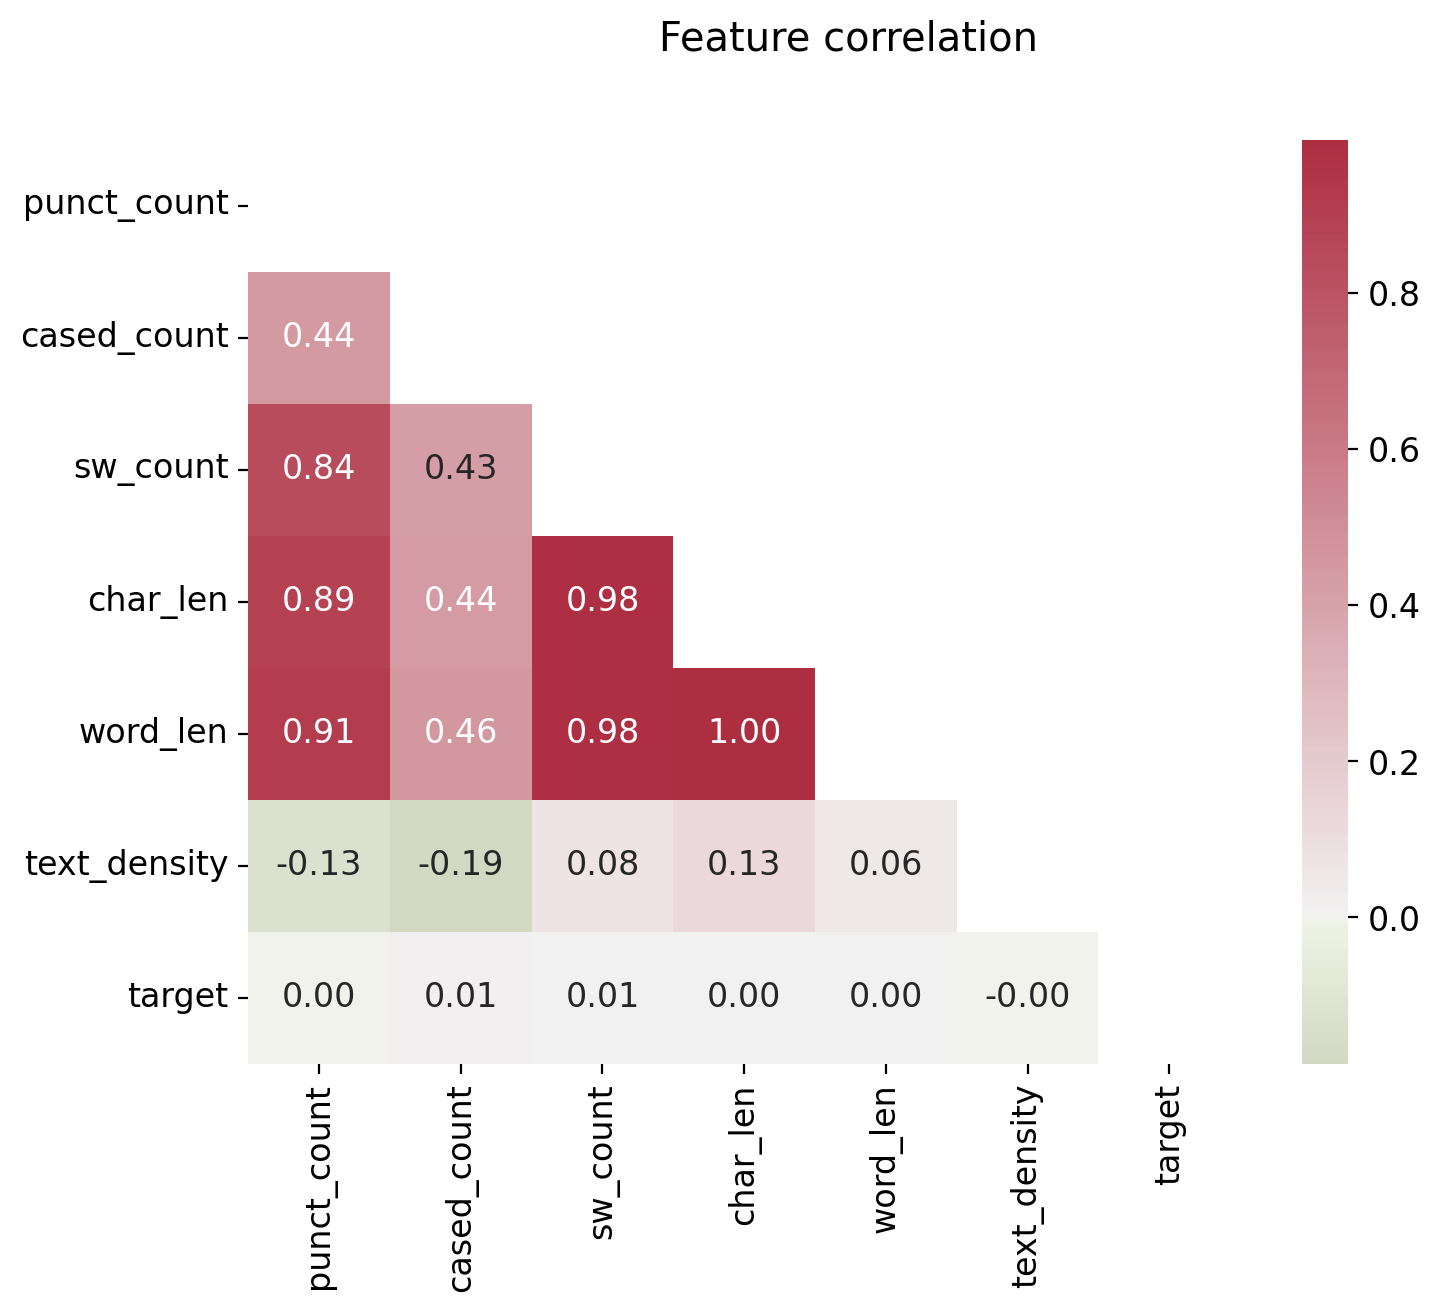

In [141]:
df_train = pd.concat([stats_train, pd.DataFrame(y_train, columns=["target"])], axis=1)
plot_heatmap(df_train, size=8)

Ну, корреляция почти несуществующая, но зато это красивый график, как все любят. Можно разве что подметить, что добавлять их все плохая идея, потому что сильная мультиколлинеарность, но я этого и не делал. Что действительно важно посмотреть, так это баланс классов, здесь всё хорошо

In [188]:
def check_imbalance(dataframe, column):
    """Function that fraws target imbalance, if any"""
    # Plot the machine failures
    plt.figure(figsize=(10, 6))

    # Countplot
    ax = plt.subplot(1, 2, 1)
    ax = sns.countplot(x=column, data=dataframe, edgecolor="black", linewidth=1.5,
                       palette=sns.color_palette("Spectral"))
    ax.bar_label(ax.containers[0])
    plt.title(f"{column.capitalize()} distibution", fontsize=13)

    # Pie chart
    ax = plt.subplot(1, 2, 2)
    outcome_counts = dataframe[column].value_counts()
    plt.pie(outcome_counts, explode=[0.05, 0.05], autopct='%1.2f%%',
            colors=sns.color_palette("Spectral"),
            wedgeprops={"edgecolor":"k",'linewidth': 1.5, 'antialiased': True})
    ax.set_title(f"{column.capitalize()} balance", fontsize=16, font='Lucida Calligraphy')
    ax.legend(labels=dataframe[column].unique())

    # Display
    plt.tight_layout()
    plt.show()
    # TODO: logscale, multiple columns??, plotly refactor, fix legend

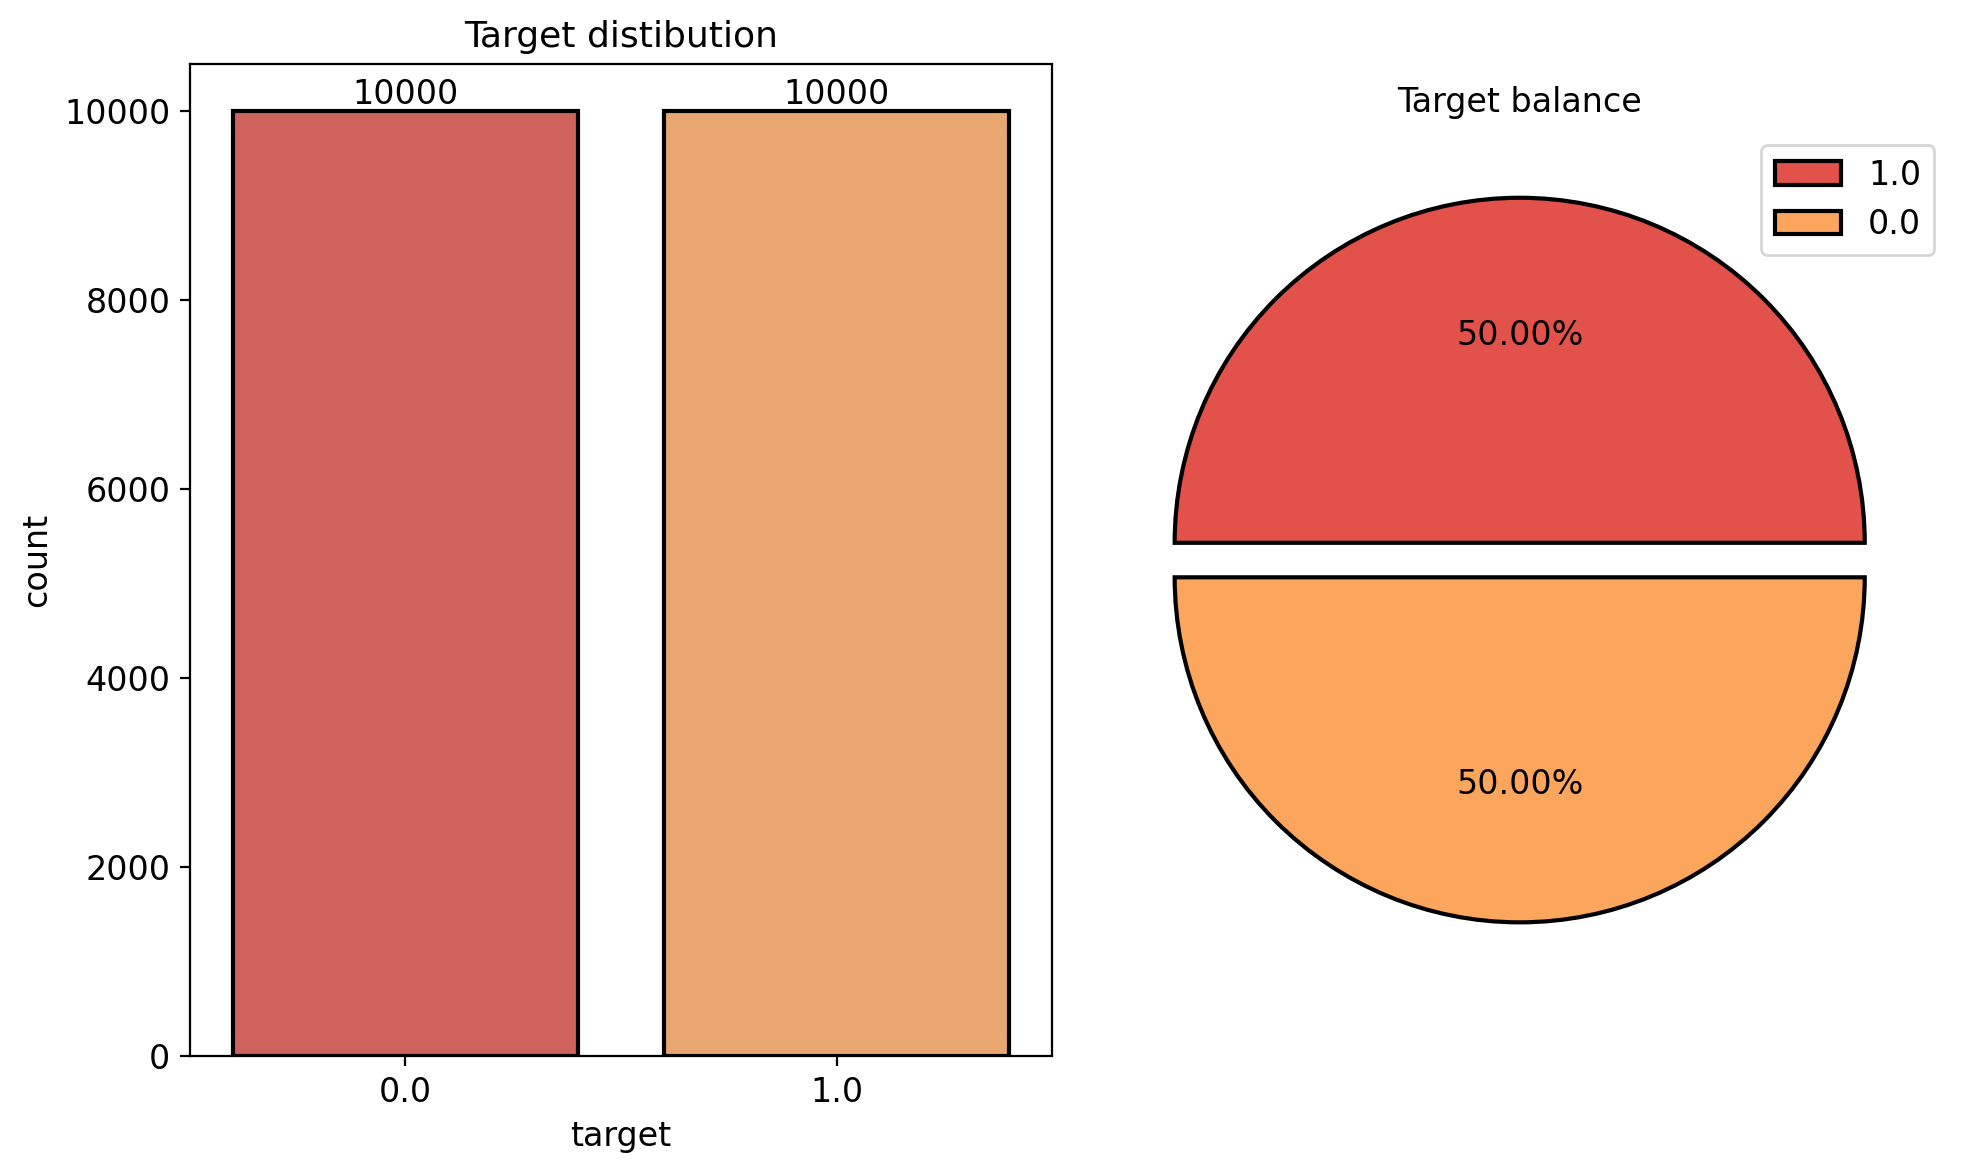

In [189]:
check_imbalance(df_train, "target")

Вдобавок можно глянуть на распределение слов, потому что это бывает прикольно, особенно в задачах кластеризации, можно также сгенерить эти фичи, если есть желание. У меня почему-то сломался nltk, поэтому я на этот момент забью

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords("english"), background_color="white").generate(X.text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3. Выбор базовой модели

Далее важный шаг - выбор модели. Я если честно, не знаю, как это лучше всего сделать, кроме как перебрать все. Если бы у меня было ограниченное время, я бы брал две - `LogisticRegression` и `CatBoostClassifier`. Первая быстрая и легко интерпретируемая, вторую можно хорошо затюнить в теории. `SVC` не очень, потому что без калибровки не возвращает вероятности, knn слишком долгий на предикте, остальные в принципе можно попробовать. Первичный отбор я делал на лемматизированном датасете, чтобы было, как по учебнику

In [93]:
X, X_test, y, y_test = download_datasets("lemmatized")
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=.2,
                                                  stratify=y, random_state=228)
# кросс-валидацию пока не делаю, иначе слишком долго
metrics = []

Функция, чтобы записывать метрики на первичном отборе. Не самая лучшая, надо бы написать её получше

In [20]:
def record_metrics(models, preprocessor=[], use_val=False, cv=False):

    for model, model_name in tqdm(models):
        # препроцессор не настраивается, это будем делать на тюнинге
        pipe = make_pipeline(*preprocessor, model)

        # накидываем датасеты, смотря, хотим ли обучаться только для валидации
        # или вообще на всём трейне
        if use_val:
            datasets = [(X_val, y_val, "val"),
                        (X_test, y_test, "test")]
            train_set = [X_train, y_train]
        else:
            datasets = [(X_test, y_test, "test")]
            train_set = [X, y]
        if len(preprocessor) > 0:
            train_set[0] = train_set[0].text
        pipe.fit(*train_set)

        for features, target, dataset in datasets:
            if len(preprocessor) > 0:
                features = features.text
            # замеряем время, это важно для работы сервиса, слишком долго => отбросим
            start_time = time.time()
            y_pred = pipe.predict(features)
            inference_time = time.time() - start_time
            # собираем все метрики
            report =  classification_report(y_pred, target, output_dict=True)
            if "svm" not in model_name:
                y_pred_proba = pipe.predict_proba(features)[:, 1]
                roc_auc = roc_auc_score(target, y_pred_proba)
                auc_pr = average_precision_score(target, y_pred_proba)
            else:
                roc_auc, auc_pr = 0, 0

            metrics.append({
                "model": model_name,
                "dataset": dataset,
                "inference_time": inference_time,
                "accuracy": report["accuracy"],
                "precision": report["macro avg"]["precision"],
                "recall": report["macro avg"]["recall"],
                "f1": report["macro avg"]["f1-score"],
                "roc_auc": roc_auc,
                "auc_pr": auc_pr})

Метрики я собирал вообще все, но можно было ограничиться accuracy и ROC-AUC, т.к. выборка сбалансирована

Посчитаем качество для униграм и биграм, это наиболее вероятные кандидаты на обучение

In [21]:
np.random.seed(777)

prefix = "unigram"

models = [
    (BernoulliNB(), f"{prefix}_nb"),
    (LogisticRegression(), f"{prefix}_logreg"),
    (LinearSVC(), f"{prefix}_svm"),
    (SVC(probability=True, kernel="linear"), f"{prefix}_proba_svc"),
#     (SVC(kernel="linear"), f"{prefix}_linear_kernel")
    (RandomForestClassifier(), f"{prefix}_random_forest"),
    (CatBoostClassifier(verbose=250), f"{prefix}_catboost")
]

preprocessor = [TfidfVectorizer()]
record_metrics(models, preprocessor=preprocessor, use_val=True)

  0%|          | 0/6 [00:00<?, ?it/s]

Learning rate set to 0.037023
0:	learn: 0.6836022	total: 1.5s	remaining: 24m 56s
250:	learn: 0.3938195	total: 3m	remaining: 8m 57s
500:	learn: 0.3214513	total: 5m 58s	remaining: 5m 57s
750:	learn: 0.2773295	total: 8m 54s	remaining: 2m 57s
999:	learn: 0.2466797	total: 11m 48s	remaining: 0us


In [22]:
metrics_df = pd.DataFrame(metrics)
metrics_df[metrics_df.dataset == "val"].sort_values("accuracy", ascending=False)

,model,dataset,inference_time,accuracy,precision,recall,f1,roc_auc,auc_pr
6,unigram_proba_svc,val,49.397370,0.8884,0.8884,0.888481,0.888394,0.956223,0.954352
4,unigram_svm,val,0.841167,0.8874,0.8874,0.887494,0.887393,0.000000,0.000000
2,unigram_logreg,val,0.920446,0.8862,0.8862,0.886252,0.886196,0.952450,0.951335
10,unigram_catboost,val,0.972381,0.8620,0.8620,0.862317,0.861970,0.938907,0.938059
8,unigram_random_forest,val,1.283854,0.8454,0.8454,0.845429,0.845397,0.923196,0.915395
0,unigram_nb,val,0.849646,0.8404,0.8404,0.843894,0.839994,0.926143,0.914936


In [23]:
np.random.seed(777)

prefix = "bigram"

models = [
    (BernoulliNB(), f"{prefix}_nb"),
    (LogisticRegression(), f"{prefix}_logreg"),
    (LinearSVC(), f"{prefix}_svm"),
    (RandomForestClassifier(), f"{prefix}_random_forest"),
#     (CatBoostClassifier(verbose=100), f"{prefix}_catboost")
]
# катбуст на самом деле посчитан, см. base_metrics.csv

preprocessor = [TfidfVectorizer(ngram_range=(1, 2))]
record_metrics(models, preprocessor=preprocessor, use_val=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
metrics_df = pd.DataFrame(metrics)
metrics_df[metrics_df.dataset == "val"].sort_values("accuracy", ascending=False)

,model,dataset,inference_time,accuracy,precision,recall,f1,roc_auc,auc_pr
16,bigram_svm,val,1.950951,0.8938,0.8938,0.893896,0.893794,0.000000,0.000000
6,unigram_proba_svc,val,49.397370,0.8884,0.8884,0.888481,0.888394,0.956223,0.954352
4,unigram_svm,val,0.841167,0.8874,0.8874,0.887494,0.887393,0.000000,0.000000
2,unigram_logreg,val,0.920446,0.8862,0.8862,0.886252,0.886196,0.952450,0.951335
14,bigram_logreg,val,1.960605,0.8828,0.8828,0.882825,0.882798,0.948548,0.948153
10,unigram_catboost,val,0.972381,0.8620,0.8620,0.862317,0.861970,0.938907,0.938059
12,bigram_nb,val,2.144800,0.8562,0.8562,0.864579,0.855369,0.945955,0.941801
8,unigram_random_forest,val,1.283854,0.8454,0.8454,0.845429,0.845397,0.923196,0.915395
18,bigram_random_forest,val,3.625016,0.8450,0.8450,0.845458,0.844949,0.922659,0.914399
0,unigram_nb,val,0.849646,0.8404,0.8404,0.843894,0.839994,0.926143,0.914936


Заодно можно проверить, помогает ли как-то предобработка (нет, но это из-за токенизации в `TfidfVectorizer`)

In [25]:
np.random.seed(777)

X, X_test, _, _ = download_datasets("tokenized")

prefix = "tokenized"

models = [
    (BernoulliNB(), f"{prefix}_nb"),
    (LogisticRegression(), f"{prefix}_logreg"),
    (LinearSVC(), f"{prefix}_svm"),
    (RandomForestClassifier(), f"{prefix}_random_forest"),
    (CatBoostClassifier(verbose=250), f"{prefix}_catboost")
]

preprocessor = [TfidfVectorizer()]
record_metrics(models, preprocessor=preprocessor, use_val=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.037023
0:	learn: 0.6836022	total: 1.05s	remaining: 17m 28s
250:	learn: 0.3938195	total: 3m	remaining: 8m 58s
500:	learn: 0.3214513	total: 5m 59s	remaining: 5m 57s
750:	learn: 0.2773295	total: 8m 56s	remaining: 2m 57s
999:	learn: 0.2466797	total: 11m 50s	remaining: 0us


In [26]:
model = CatBoostClassifier(verbose=0, text_features=["text"])
record_metrics([(model, "catencoder_catboost")], use_val=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
metrics_df = pd.DataFrame(metrics)
metrics_df[metrics_df.dataset == "val"].sort_values("accuracy", ascending=False)

,model,dataset,inference_time,accuracy,precision,recall,f1,roc_auc,auc_pr
16,bigram_svm,val,1.950951,0.8938,0.8938,0.893896,0.893794,0.000000,0.000000
6,unigram_proba_svc,val,49.397370,0.8884,0.8884,0.888481,0.888394,0.956223,0.954352
4,unigram_svm,val,0.841167,0.8874,0.8874,0.887494,0.887393,0.000000,0.000000
24,tokenized_svm,val,0.829739,0.8874,0.8874,0.887494,0.887393,0.000000,0.000000
30,catencoder_catboost,val,0.412930,0.8868,0.8868,0.886909,0.886792,0.954862,0.954302
2,unigram_logreg,val,0.920446,0.8862,0.8862,0.886252,0.886196,0.952450,0.951335
22,tokenized_logreg,val,0.884792,0.8862,0.8862,0.886252,0.886196,0.952450,0.951335
14,bigram_logreg,val,1.960605,0.8828,0.8828,0.882825,0.882798,0.948548,0.948153
10,unigram_catboost,val,0.972381,0.8620,0.8620,0.862317,0.861970,0.938907,0.938059
28,tokenized_catboost,val,1.019481,0.8620,0.8620,0.862317,0.861970,0.938907,0.938059


Все метрики доступны в этом файлике, если очень интересно

In [28]:
metrics_df.to_csv("base_metrics.csv", index=0)

Есть ещё одна вещь, которую предлагают авторы статьи - попробовать `Word2Vec`. Я скептически к этом отношусь, на мой взгляд, для моделей эти эмбеддинги ничем не лучше, но для чистоты эксперимента почему бы и нет. В архиве есть уже готовые, но это не интересно

In [94]:
from gensim.models import Word2Vec

metrics = []
w2v = Word2Vec(vector_size=300, sentences=X.text.apply(lambda x: x.split()))

In [95]:
w2v.wv.most_similar("violence")

[('gratuitous', 0.856247067451477),
 ('nudity', 0.8476272225379944),
 ('extreme', 0.8355801701545715),
 ('explicit', 0.8317248821258545),
 ('excessive', 0.8085965514183044),
 ('sexual', 0.7750259637832642),
 ('violent', 0.7603166103363037),
 ('gore', 0.755864143371582),
 ('profanity', 0.7549787759780884),
 ('gory', 0.7524906992912292)]

In [249]:
def word2vec_transformer(string):
    return np.mean([w2v.wv.get_vector(w) 
                    for w in string.split() 
                    if w in w2v.wv.key_to_index], 0)

In [251]:
X_train = np.vstack(X_train.text.progress_apply(word2vec_transformer).values)
X_val = np.vstack(X_val.text.progress_apply(word2vec_transformer).values)
X_test = np.vstack(X_test.text.progress_apply(word2vec_transformer).values)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [253]:
metrics= []
prefix = "w2v"

models = [
    (BernoulliNB(), f"{prefix}_nb"),
    (LogisticRegression(), f"{prefix}_logreg"),
    (LinearSVC(), f"{prefix}_svm"),
    (RandomForestClassifier(), f"{prefix}_random_forest"),
    (CatBoostClassifier(verbose=0), f"{prefix}_catboost")
]

record_metrics(models, use_val=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [254]:
metrics_df = pd.DataFrame(metrics)
metrics_df[metrics_df.dataset == "val"].sort_values("accuracy", ascending=False)

,model,dataset,inference_time,accuracy,precision,recall,f1,roc_auc,auc_pr
4,w2v_svm,val,0.007047,0.8230,0.8230,0.823023,0.822997,0.000000,0.000000
2,w2v_logreg,val,0.009725,0.8172,0.8172,0.817201,0.817200,0.895014,0.890229
8,w2v_catboost,val,0.073740,0.8024,0.8024,0.802485,0.802386,0.886508,0.882440
6,w2v_random_forest,val,0.147221,0.7752,0.7752,0.775285,0.775183,0.855443,0.849151
0,w2v_nb,val,0.060080,0.6926,0.6926,0.694173,0.691976,0.771788,0.743388


Итоги неутешительные, зато обучение очень быстрое, ведь признаков немного. Да, обучение эмбеддингов можно подкрутить, можно взять готовые, можно взять fasttext, но можно и не брать. Я брать не люблю

### Подведём итоги:

#### 1. LinearSVC, acc=0.894

Показал лучшее аккураси, если бы в ТЗ конкретно не оговаривалось, что нужен рейтинг, а не только сентимент, я бы взял его, его и затюнить по-моему можно лучше, чем логрег. Но проблема в том, что вероятности он не возвращает, можно, конечно, откалибровать, но пострадает время инференса, я пробовал, поэтому ищем другой вариант. Ещё стоит отметить, что у модели уже лучше качество, чем максимальное в статье внизу, причём на тесте тоже, ещё один довод не в пользу Word2vec.

#### 2. CatBoost, acc=0.887

Катбуст показывает хорошие результаты, если пользоваться встроенным энкодером, вполне возможно, что у него большой потенциал для тюнинга. Я пробовал, но занимает слишком много времени, к тому же для него нужен GPU. Если бы датасет был поменьше, взял бы его.

#### 3. LogisticRegression, acc=0.886

Мой фаворит в этой задаче. Качество всего на процент хуже, но есть вероятности, это очень важно. Ну и в принципе возможностей для тюнинга тоже достаточно, вкупе с относительной простотой можно попробовать неплохо дожать качество

#### 4. NB & RandomForest

Байес я обучил просто так, потому что он это делает моментально, на случай, если. Случайный лес тоже, мне было интересно, справится ли он хоть с какой-то задачей лучше бустинга, пока не получилось ни разу.

[Статья, на которую ссылались в ТЗ](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)

## 4. Тюнинг модели

In [228]:
X, X_test, y, y_test = download_datasets("tokenized")

In [31]:
import warnings
warnings.filterwarnings("ignore")

Тюнить я буду естественно через библиотеку, сетки это прошлый век. С логистической регрессией можно сделать не очень много, в оснвном это просто разные виды регуляризации и разное число итераций градиентного спуска. Вот векторайзер можно покрутить поинтереснее, особенно `token_pattern`, чтобы учесть ту самую пунктуацию, смалийки и т.д., а также параметр `analyzer`, символьные нграммы это по сути местный фасттекст, бывает очень полезно 

In [ ]:
np.random.seed(69)

def logreg_objective(trial):
    
    # model parameters
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
        "C": trial.suggest_float("C", 0.0, 15.0),
        "tol": trial.suggest_float("tol", 1e-6, 1e-1, log=True),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "max_iter": trial.suggest_int("max_iter", 25, 1500),
        "random_state": 777
    }
    
    # different solvers might find different optima
    if params["penalty"] == "elasticnet":
        params["solver"] = "saga"
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)
    elif params["penalty"] == "l1":
        params["solver"] = trial.suggest_categorical("l1_solver", ["liblinear", "saga"])
    else:
        params["solver"] = trial.suggest_categorical("l2_solver", ["liblinear", "saga",
                                                                   "lbfgs", "newton-cg"])
        
    # tfidf parameters are as important as the model's
    tfidf_params = {
        "use_idf": trial.suggest_categorical('use_idf', [True, False]),
        "analyzer": trial.suggest_categorical('analyzer', ["word", "char"]),
        "stop_words": trial.suggest_categorical('stop_words', [None, "english"]),
        "lowercase": trial.suggest_categorical('lowercase', [True, False]),
        "min_df": trial.suggest_int("min_df", 1, 20),
        "token_pattern": trial.suggest_categorical("token_pattern", ['(?u)\\b\\w\\w+\\b',
                                                                     '\S+'])
    }
    
    if tfidf_params["analyzer"] == "char":
        tfidf_params["ngram_range"] = (1, trial.suggest_int('ngram_range', 1, 3))
    else:
        tfidf_params["ngram_range"] = (1, trial.suggest_int('ngram_range', 1, 2))

    # hparam choice is based on cross-validation, obviously
    model = LogisticRegression(**params)
    pipe = make_pipeline(TfidfVectorizer(**tfidf_params), model)
    # other metrics are irrelevant, thanks to dataset balance
    optuna_score = cross_val_score(pipe, X.text, y, scoring="accuracy", cv=5)

    clear_output(True)
    return np.mean(optuna_score)

logreg_study = optuna.create_study(direction = 'maximize')
logreg_study.optimize(logreg_objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

Результаты получились вот такие. Почти 90.5% аккураси, отсюда уже вряд ли можно выжать больше, разве что из бустинга, его тюнинг я заготовил в `catboost_tuning.ipynb`, но он не закончен

In [33]:
logreg_study.best_value, logreg_study.best_params

(0.90672,
 {'penalty': 'l2',
  'C': 13.991882149161302,
  'tol': 2.3655997265491263e-06,
  'fit_intercept': True,
  'max_iter': 32,
  'l2_solver': 'saga',
  'use_idf': True,
  'analyzer': 'word',
  'stop_words': None,
  'lowercase': True,
  'min_df': 5,
  'token_pattern': '\\S+',
  'ngram_range': 2})

На случай, если выходы потрутся

In [13]:
best_params = {'penalty': 'l2',
               'C': 13.991882149161302,
               'tol': 2.3655997265491263e-06,
               'fit_intercept': True,
               'max_iter': 32,
               'solver': 'saga'}
best_tfidf_params = {'use_idf': True,
                     'analyzer': 'word',
                     'stop_words': None,
                     'lowercase': True,
                     'min_df': 5,
                     'token_pattern': '\\S+',
                     'ngram_range': (1, 2)}

Теперь замерим качество на тесте и посмотрим, имело ли это вообще смысл

In [14]:
X, X_test, y, y_test = download_datasets("tokenized")

In [16]:
tfidf = TfidfVectorizer()
model = LogisticRegression(random_state=777)
pipe = make_pipeline(tfidf, model)

pipe.fit(X.text, y)
proba = pipe.predict_proba(X_test.text)[:, 1]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
tfidf = TfidfVectorizer(**best_tfidf_params)
model = LogisticRegression(**best_params, random_state=777)
optimized_pipe = make_pipeline(tfidf, model)

optimized_pipe.fit(X.text, y)
optimized_proba = optimized_pipe.predict_proba(X_test.text)[:, 1]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Для совсем жёсткой оптимизации остаётся только выбрать порог. В идеале тоже по кросс-валидации, но мне кажется. что она может быть не очень, если у модели слишком большой разброс

In [18]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import StratifiedKFold

def find_best_threshold(X, y, model, test_size=.2, metrics="f1"):
    # выбор трешхолда только по кросс-валидации
    skf = StratifiedKFold(n_splits=5, random_state=228, shuffle=True)
    splits = [split for split in skf.split(X, y)]

    threshold_candidates, fold_scores = [], []
    for train_index, test_index in tqdm(splits):
        model.fit(X[train_index], y[train_index])
        y_pred = model.predict_proba(X[test_index])[:, 1]
        y_true = y[test_index]

        if metrics == "f1":
            # все метрики для трешхолдов удобно достоаются из PR-кривой, дальше магия нампая
            precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
            # f1 обычно наиболее репрезентативен, так что по дефолту считается он
            f1_scores = 2*recall*precision/(recall+precision)
            # веса лишними не бывают
            weights = confusion_matrix(y_true, y_pred).sum(axis=1)
            scores = np.average(scores, weights=weights)

        elif metrics == "accuracy":
            # для аккураси можно воспользоваться ROC-кривой, в остальном всё то же
            fpr, tpr, thresholds = roc_curve(y_true, y_pred)
            scores = []
            for t in thresholds:
                scores.append(accuracy_score(y_true, [value > t for value in y_pred]))
            scores = np.array(scores)
            
        # вот это мне не очень нравится, если усреднять, может быть большой разброс
        threshold_candidates.append(thresholds[scores.argmax()])
        fold_scores.append(scores.max())
    
    return np.array(threshold_candidates), np.array(fold_scores)

In [19]:
best_t, t_scores = find_best_threshold(X.text, y, optimized_pipe, metrics="accuracy")
print("Thresholds:", best_t, best_t.mean())
print("Metrics:", t_scores, t_scores.mean())

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Thresholds: [0.47820185 0.47362497 0.47800357 0.5430436  0.54398122] 0.5033710419245171
Metrics: [0.9046 0.9084 0.9076 0.9126 0.9106] 0.90876


In [20]:
print("Default")
print(f"Accuracy: {accuracy_score(proba > 0.5, y_test)}")
print(f"ROC-AUC: {roc_auc_score(y_test, proba)}\n")

print("Optimized")
print(f"Accuracy: {accuracy_score(optimized_proba > 0.5, y_test)}")
print("Optimized with chosen threshold")
print(f"Accuracy: {accuracy_score(optimized_proba > np.mean(best_t), y_test)}")
print(f"ROC-AUC: {roc_auc_score(y_test, optimized_proba)}")

Default
Accuracy: 0.883
ROC-AUC: 0.9523968319999999

Optimized
Accuracy: 0.90488
Optimized with chosen threshold
Accuracy: 0.90512
ROC-AUC: 0.9655946304


Следующий шаг - посмотреть, насколько наша модель хорошо приближает вероятности, это можно сделать, взглянув на калибровочную кривую. У меня есть кастомная функция, которая её рисует

In [21]:
def plot_calibration_curve(y_test, preds_list, n_bins=10):
    
    fig = go.Figure()
    for name in preds_list:
        preds = preds_list[name]
        bin_middle_points = []
        bin_real_ratios = []
        n_bins = n_bins
        for i in range(n_bins):
            l = 1.0 / n_bins * i
            r = 1.0 / n_bins * (i + 1)
            bin_middle_points.append((l + r) / 2)
            bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)])) 
        score = average_precision_score(y_test, preds)
        fig.add_trace(go.Scatter(x=bin_middle_points,
                                 y=bin_real_ratios,
                                 name=f"{name}<br>(PR={score :.5f})", mode='markers+lines'))
        
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0.05, x1=0.95, y0=0.05, y1=0.95
    )
    fig.update_layout(
        title=f"Calibration curves, n_bins={n_bins}",
        xaxis_title="bins",
        yaxis_title="model probability",
        legend_title="Classifier",
        height=500)
    fig.show()

Если совсем упороться, модель можно ещё больше откалибровать. С логрегом это звучит глупо, он и так откалиброван, к тому же это долго и может поломать аккураси, но почему бы и нет, для эксперимента

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(optimized_pipe, cv=5)
calibrated_clf.fit(X.text, y)
calibrated_proba = calibrated_clf.predict_proba(X_test.text)[:, 1]

In [23]:
plot_calibration_curve(y_test, {"Default LogReg": proba,
                                "Optimized LogReg": optimized_proba,
                                "Calibrated LogReg": calibrated_proba},
                       n_bins=25)

Как видно, оптимизация очень даже имела смысл. Аккураси на самом деле даже не так важен, потому что главная цель - предсказывать рейтинг, а это делается только через вероятности, которых нам не дали. Судя по кривой, калибровка очень даже неплохая, это явно успех. Может быть, можно дожать до 0.91, если очень упороться, судя по качеству на выборе трешхолда, у меня один раз так вышло, когда я не зафиксировал `random_state`, но это уже похоже на шаманизм

In [24]:
import pickle

pickle.dump(optimized_pipe, open("logreg_0.905", 'wb'))

## 5. Интерпретация модели

Сперва посмотрим на все-все веса признаков, которые есть в пайплайне

Интерпретировать линейные модели всегда легко и приятно, поэтому я решил это тоже сделать и интегрировать в сайт


In [31]:
logreg = pickle.load(open("/kaggle/input/imdb-models/logreg_0.905", "rb"))

In [76]:
coefficients = logreg[1].coef_[0]

feature_importance = pd.DataFrame({'feature': logreg[0].get_feature_names_out(),
                                   'abs_importance': np.abs(coefficients),
                                   'rel_importance': coefficients})
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

In [33]:
# я буду сэмплить из лог-распределения, мне понадобятся ближайшие значения,
# их самих в датасете не будет

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [34]:
# сэмплим слова
fi_values = feature_importance.abs_importance.values
samples = np.logspace(fi_values.min(),
                      fi_values.max(),
                      500)
nearest_samples = list(set([find_nearest_idx(fi_values, s) for s in samples]))

In [35]:
# рисуем
sub_df = feature_importance.iloc[nearest_samples].sort_values("rel_importance")
fig = px.bar(sub_df, x='feature', y='rel_importance', color="rel_importance",
             color_continuous_scale=[[0, 'red'], [1, 'green']])
fig.update_layout(title="Feature importance",
                  xaxis = dict(tickmode = 'linear', showgrid = True))
fig.update_xaxes(tickangle=-45)
fig.show()

Видно, что вместе с ожидаемыми словами, типа "great" или "worse", внесли свой вклад и стопслова, и даже смайлики, а значит, предобработка не нужна, твёрдо и чётко

In [78]:
# потом пригодится
feature_importance.to_csv("feature_importance.csv", index=0)

Дальше на кривом плотли функция, которая будет оценивать важность непосредственно тех слов, которые есть в сообщении. Интерсепт, кстати, показывать нет смысла, он оказался почти нулевой

In [87]:
from plotly.subplots import make_subplots


# лучше один раз сделать этот датасет, чем постоянно вызывать заново
feature_importance = pd.read_csv("feature_importance.csv").set_index("feature")

def compute_message_feature_importance(text, rating):

    _, inds = logreg[0].transform([text]).nonzero()
    important_words = logreg[0].get_feature_names_out()[inds]
    # цвета для рейтинга
    colors = ["#d20d39", "#c21a48", "#b52755", "#a83463", "#984171",
              "#8a4d7d", "#7C5B8C", "#6D689A", "#5E76A8", "#5281B4"]

    coefficients = logreg[1].coef_[0]
    local_importance = feature_importance.loc[important_words]["rel_importance"]
    sub_df = local_importance.sort_values()

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Predicted rating",
                                        "Word importance in given text"),
                        column_widths=[0.1, 0.9], horizontal_spacing = 0.05)

    # во второй колонке будет график важностей слов
    fig.add_trace(
        go.Bar(x=sub_df.index, y=sub_df.values, showlegend=False,
               name="importance",
               marker=dict(
                color=sub_df.values,
                colorbar=dict(title="importance"),
                colorscale=[[0, 'crimson'], [1, 'steelblue']]
                )
              ),
        row=1, col=2
    )

    # в первой колонке будет показан предсказанный рейтинг
    fig.add_trace(
        go.Bar(y=[rating], showlegend=False, name="rating",
               marker_color=colors[rating-1]),
        row=1, col=1
    )

    fig.update_layout(yaxis_range=[-0.25, 10.25],
                      yaxis=dict(tickvals=list(range(0, 11))), title_x=0.5,
                      height=600, autosize=True, template="simple_white")

    # если слов много, может быть тяжело отследить конкретное
    showgrid = False
    if len(set(text.split())) > 15:
        showgrid = True
    
    # дальше просто приукрашивание графика
    fig['layout']["xaxis1"].update(showticklabels=False, mirror=True, showline=True)
    fig['layout']["yaxis1"].update(tickvals=list(range(0, 11)), title="rating", mirror=True, showline=True)
    fig['layout']["xaxis2"].update(tickangle=-45, title="feature",
                                   mirror=True, showline=True, showgrid=showgrid)
    fig['layout']["yaxis2"].update(title="", showgrid=False, mirror=True, showline=True)
    fig.update_annotations(yshift=20)
    fig.show()
#     fig.write_html("mysite/templates/temp.html")

На сам график глянем ниже

## 6. Инференс

Для сайта, да и для хорошего тона, модель должна работать через интерфейс

In [38]:
import pickle

logreg = pickle.load(open("/kaggle/input/imdb-models/logreg_0.905", 'rb'))
xlnet = ... # предполагалось, что нейросети тоже будет, см. dl_training.ipynb

def ml_infer(text):
    return logreg.predict_proba([text])[:, 1].item()

def dl_infer(text):
    pass
    
# рейтинг оценивается точно, как принято в статье
def rating_estimate(text, model="logreg"):
    proba = {"logreg": ml_infer(text), "roberta": dl_infer(text)}[model]
    rating = int(np.round(proba * 10))
    if rating >= 7:
        sentiment = "positive"
    elif rating <= 4:
        sentiment = "negative"
    else:
        sentiment = "mixed"
    return max(1, rating), sentiment

In [39]:
%%time
print(rating_estimate("This movie is utter dogshit, how could anyone possibly like it???"))
print(rating_estimate("I enjoyed it a lot however"))
print(rating_estimate("It was mediocre for the most part, but the ending was brilliant, dare I say"))

(1, 'negative')
(10, 'positive')
(4, 'negative')
CPU times: user 8.5 ms, sys: 1.94 ms, total: 10.4 ms
Wall time: 9.18 ms


Ну и посмотрим на какой-нибудь относительно сложный текст

In [89]:
text = "It’s funny, it’s bright and uplifting, and I think has a lot to say about the modern world – both in terms of feminism and gender equality. Ryan Gosling really goes all-out."

print(ml_infer(text))
print(rating_estimate(text))
compute_message_feature_importance(text, rating_estimate(text)[0])

0.9082365956610743
(9, 'positive')


Кажется, вполне неплохо! Кстати, феминизм негативный терм, интересно...

<img src="https://cdn.discordapp.com/attachments/674191702906503199/1135968040484339782/image.png">